In [1]:
# spark libraries
import pyspark
from pyspark.sql.functions import max

# data wrangling
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('hard_drives_smart_5.csv').drop(columns='Unnamed: 0')

In [3]:
df.head()

,serial_number,model,capacity_bytes,max(failure),max(smart_9_raw),max(smart_5_raw),max(smart_187_raw),max(smart_188_raw),max(smart_197_raw),max(smart_198_raw)
0,PL1311LAG1SJAA,Hitachi HDS5C4040ALE630,4000787030016,0,43819.0,0.0,NaN,NaN,0.0,0.0
1,Z305KB36,ST4000DM000,4000787030016,0,31045.0,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi HDS5C3030ALA630,3000592982016,0,41668.0,0.0,NaN,NaN,0.0,0.0
3,ZA11NHSN,ST8000DM002,8001563222016,0,26284.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi HDS5C3030ALA630,3000592982016,0,47994.0,0.0,NaN,NaN,0.0,0.0


In [4]:
def prepare(df):
    
    # Convert capacity column from bytes to gigabytes
    df['capacity_bytes'] = round((df['capacity_bytes']/ 1_000_000_000),0)

    # Convert power hours to years
    df['max(smart_9_raw)'] = round((df['max(smart_9_raw)']/ 8760),1)

    # Create a new column for manufacturer
    df['manufacturer'] = df.model.apply(get_manufacturer)
    
    # Rename columns appropriately
    df = df.rename(columns={'capacity_bytes':'capacity_gigabytes',
                        'max(failure)':'failure',
                        'max(smart_9_raw)':'drive_age_in_years',
                        'max(smart_5_raw)':'reallocated_sectors_count',
                        'max(smart_187_raw)':'reported_uncorrectable_errors',
                        'max(smart_188_raw)':'command_timeout',
                        'max(smart_197_raw)':'current_pending_sector_count',
                        'max(smart_198_raw)':'uncorrectable_sector_count'})

    # Reorder columns 
    df = df[['serial_number','manufacturer','model','capacity_gigabytes',
          'failure','drive_age_in_years','reallocated_sectors_count',
         'reported_uncorrectable_errors','command_timeout',
          'current_pending_sector_count','uncorrectable_sector_count']]
    
    return df


def unique(df):
    '''
    Remove rows that duplicate serial numbers after aggregation.
    '''
    
    # remove rows with 0 copacity_gigabytes they were creating duplicate rows for some of the serial numbers
    df = df[df.capacity_gigabytes > 0]
    
    # remove rows by index that were creating duplicate serial numbers 
    df = df.drop([68273,50408,37150,154660,162948,50816,156370,31687,20823,75191,132189,4177,78104,103620,141505,95249,26969])
    
    return df

def get_manufacturer(model):
    if model.startswith('ST'):
        return 'Seagate'
    elif model.startswith('Sea'):
        return 'Seagate'
    elif model.startswith('HGST'):
        return 'Hitachi'
    elif model.startswith('Hit'):
        return 'Hitachi'
    elif model.startswith('TOS'):
        return 'Toshiba'
    elif model.startswith('DEL'):
        return 'Dell'
    elif model.startswith('WD'):
        return 'Western Digital'
    elif model.startswith('Sam'):
        return 'Samsung'
    elif model.startswith('SAM'):
        return 'Samsung'
    else:
        return 'Unknown'

def treat_nulls(df):
    # remove nulls from specific columns by imputing zeroes
    df.reported_uncorrectable_errors = df.reported_uncorrectable_errors.fillna(value=0)
    df.command_timeout = df.command_timeout.fillna(value=0)
    
    # treat remaining nulls by dropping specific rows
    df = df.dropna(axis=0)
    return df

In [5]:
df = prepare(df)

In [6]:
df = unique(df)

In [7]:
df = treat_nulls(df)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 11 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_gigabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
dtypes: float64(7), int64(1), object(3)
memory usage: 14.8+ MB


In [9]:
import seaborn as sns 
import matplotlib.pyplot as plt

In [10]:
df_fails = df [df.failure == 1]
df_lives = df [df.failure == 0]

In [11]:
df_fails.drive_age_in_years.value_counts(bins=10, sort=False)

(-0.011300000000000001, 1.03]    1450
(1.03, 2.06]                     1840
(2.06, 3.09]                     1164
(3.09, 4.12]                     1095
(4.12, 5.15]                      280
(5.15, 6.18]                       65
(6.18, 7.21]                       11
(7.21, 8.24]                        1
(8.24, 9.27]                        1
(9.27, 10.3]                        4
Name: drive_age_in_years, dtype: int64

In [12]:
df_lives.drive_age_in_years.value_counts(bins=10, sort=False)

(-0.0092, 0.82]    24004
(0.82, 1.64]       15924
(1.64, 2.46]       30528
(2.46, 3.28]       20580
(3.28, 4.1]        29677
(4.1, 4.92]        24448
(4.92, 5.74]        9050
(5.74, 6.56]        1506
(6.56, 7.38]         161
(7.38, 8.2]           41
Name: drive_age_in_years, dtype: int64

In [13]:
df_fails.drive_age_in_years.agg(['mean','median'])

mean      2.064642
median    1.800000
Name: drive_age_in_years, dtype: float64

In [14]:
df_lives.drive_age_in_years.agg(['mean','median'])

mean      2.747618
median    2.700000
Name: drive_age_in_years, dtype: float64

In [15]:
df_fails.describe()

,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
count,5911.000000,5911.0,5911.000000,5911.000000,5911.000000,5.911000e+03,5911.000000,5911.000000
mean,5796.514803,1.0,2.064642,1440.317205,75.532905,2.118090e+09,164.342582,155.387075
std,3519.640805,0.0,1.311870,6376.777343,1973.510975,1.164497e+11,2359.707545,2336.187420
min,80.000000,1.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4001.000000,1.0,1.100000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,4001.000000,1.0,1.800000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,8002.000000,1.0,3.000000,16.000000,3.000000,0.000000e+00,24.000000,16.000000
max,14001.000000,1.0,10.300000,65392.000000,65535.000000,8.933668e+12,142616.000000,142616.000000


In [16]:
df_lives.describe()

,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
count,155919.000000,155919.0,155919.000000,155919.000000,155919.000000,1.559190e+05,155919.000000,155919.000000
mean,7185.167061,0.0,2.747618,17.904720,1.143299,1.378444e+08,0.273533,0.247019
std,3793.669950,0.0,1.526695,632.245333,219.129699,9.649409e+09,12.603720,12.470573
min,80.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,4001.000000,0.0,1.600000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,6001.000000,0.0,2.700000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
75%,12000.000000,0.0,4.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
max,14001.000000,0.0,8.200000,65312.000000,65535.000000,3.564877e+12,3568.000000,3568.000000


In [17]:
df.model.value_counts() [df.model.value_counts() > 100]

ST12000NM0007              38271
ST4000DM000                36156
HGST HMS5C4040BLE640       16314
ST8000NM0055               14810
HGST HUH721212ALN604       10875
ST8000DM002                10160
HGST HMS5C4040ALE640        8637
Hitachi HDS5C3030ALA630     4563
Hitachi HDS722020ALA330     4503
Hitachi HDS5C4040ALE630     2639
ST6000DX000                 1912
HGST HUH721212ALE600        1564
TOSHIBA MG07ACA14TA         1302
ST10000NM0086               1235
WDC WD30EFRX                1167
HGST HUH728080ALE600        1082
Hitachi HDS723030ALA640     1000
ST500LM012 HN                804
TOSHIBA MQ01ABF050           589
WDC WD60EFRX                 471
ST4000DM001                  425
TOSHIBA MQ01ABF050M          410
WDC WD5000LPVX               343
WDC WD10EADS                 295
ST31500541AS                 264
ST500LM030                   261
ST4000DX000                  212
WDC WD20EFRX                 158
TOSHIBA MD04ABA400V          147
HGST HDS5C4040ALE630         116
WDC WD1600

In [18]:
df_fails.columns

Index(['serial_number', 'manufacturer', 'model', 'capacity_gigabytes',
       'failure', 'drive_age_in_years', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count'],
      dtype='object')

In [19]:
# for col in df_fails.columns[6:]:
#     sns.scatterplot(data=df, y=df[col], x=df.drive_age_in_years)
#     plt.title(col)
#     plt.show()

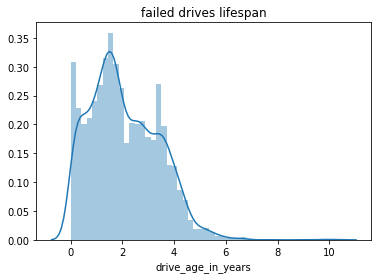

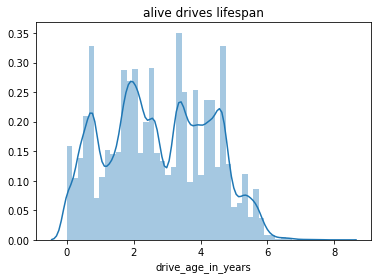

In [20]:
# plt.figure(figsize=(12,8))
sns.distplot(df_fails.drive_age_in_years)
plt.title('failed drives lifespan')
plt.show()

sns.distplot(df_lives.drive_age_in_years)
plt.title('alive drives lifespan')
plt.show()

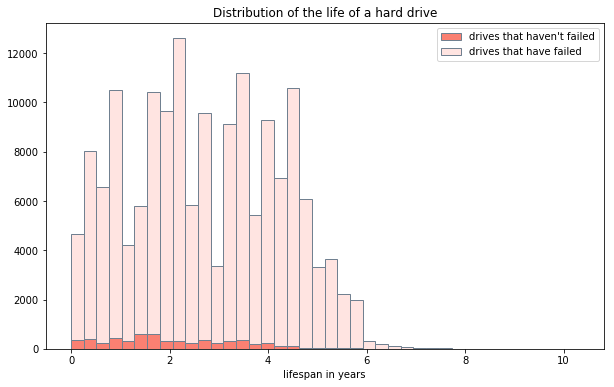

In [21]:
plt.figure(figsize=(10,6))
plt.hist([df_fails.drive_age_in_years, df_lives.drive_age_in_years], 
         stacked=True, bins=40, edgecolor='slategrey', color=['salmon','mistyrose'])
plt.legend(["drives that haven't failed","drives that have failed"])
plt.title("Distribution of the life of a hard drive")
plt.xlabel("lifespan in years")
# plt.yticks([])
plt.show()

In [22]:
df['smart_9_nonzero'] = np.where(df.reallocated_sectors_count > 0, '1','0').astype(int)
df['smart_187_nonzero'] = np.where(df.reported_uncorrectable_errors > 0, '1', '0').astype(int)
df['smart_188_nonzero'] = np.where(df.command_timeout > 0, '1', '0').astype(int)
df['smart_197_nonzero'] = np.where(df.current_pending_sector_count > 0, '1', '0').astype(int)
df['smart_198_nonzero'] = np.where(df.uncorrectable_sector_count > 0, '1', '0').astype(int)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161830 entries, 0 to 169067
Data columns (total 16 columns):
serial_number                    161830 non-null object
manufacturer                     161830 non-null object
model                            161830 non-null object
capacity_gigabytes               161830 non-null float64
failure                          161830 non-null int64
drive_age_in_years               161830 non-null float64
reallocated_sectors_count        161830 non-null float64
reported_uncorrectable_errors    161830 non-null float64
command_timeout                  161830 non-null float64
current_pending_sector_count     161830 non-null float64
uncorrectable_sector_count       161830 non-null float64
smart_9_nonzero                  161830 non-null int64
smart_187_nonzero                161830 non-null int64
smart_188_nonzero                161830 non-null int64
smart_197_nonzero                161830 non-null int64
smart_198_nonzero                161830 non-nul

In [24]:
df.groupby('failure').sum().iloc[:,7:]

,smart_9_nonzero,smart_187_nonzero,smart_188_nonzero,smart_197_nonzero,smart_198_nonzero
failure,,,,,
0,3693,1679,3813,1742,1440
1,1909,2079,559,2489,2190


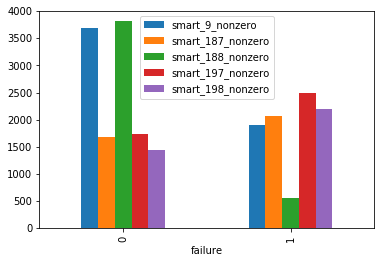

In [25]:
df.groupby('failure').sum().iloc[:,7:].plot.bar()
plt.show()

In [26]:
df.drop(columns = ['smart_9_nonzero','smart_187_nonzero', 'smart_188_nonzero','smart_197_nonzero', 'smart_198_nonzero'], inplace=True)

In [27]:
from sklearn.linear_model import LogisticRegression

In [28]:
df

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4001.0,0,5.0,0.0,0.0,0.0,0.0,0.0
1,Z305KB36,Seagate,ST4000DM000,4001.0,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3001.0,0,4.8,0.0,0.0,0.0,0.0,0.0
3,ZA11NHSN,Seagate,ST8000DM002,8002.0,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3001.0,0,5.5,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
169052,ZJV5HDV2,Seagate,ST12000NM0007,12000.0,0,0.0,0.0,0.0,0.0,0.0,0.0
169053,AAG779PH,Hitachi,HGST HUH721212ALN604,12000.0,0,0.6,0.0,0.0,0.0,0.0,0.0
169054,AAG6XZGH,Hitachi,HGST HUH721212ALN604,12000.0,0,0.6,0.0,0.0,0.0,0.0,0.0
169055,Z302ZCWX,Seagate,ST4000DM000,4001.0,0,0.1,0.0,0.0,0.0,0.0,0.0


In [30]:
def remove_manufacturers(df):
    
    # Remove manufactures with low value counts
    df = df[(df.manufacturer != 'Samsung') & (df.manufacturer != 'Unknown')]
    return df


def early_failure(df,cut_off=1.6):
    '''
    Add column to identify early failures based on the age of the hard drive 

    '''
    df['early_failure'] = np.where((df.drive_age_in_years <= cut_off) & (df.failure == 1), 1, 0)
    # df['early_failure']= 1
    # df['early_failure'][df.drive_age_in_years<=cut_off] = 1
    # df['early_failure'][df.drive_age_in_years>cut_off] = 0
    
    return df

def old_or_fail(df,cut_off=1.6):
    '''
    Retain rows for drives that have failed or are older than the cut off age
    '''

    df = df[(df.failure==1)|(df.drive_age_in_years > cut_off)]

    return df


def get_quartile(df,Q1=1.6,Q2=2.6,Q3=4):
    '''
    Add colulmn to identify which quartile drive falls in based on the age of the hard drive
    '''
    
    df['quartile']= 1
    df['quartile'][df.drive_age_in_years<Q1] = 'Q1'
    df['quartile'][(df.drive_age_in_years>=Q1) & (df.drive_age_in_years<Q2)] = 'Q2'
    df['quartile'][(df.drive_age_in_years>=Q2) & (df.drive_age_in_years<Q3)] = 'Q3'
    df['quartile'][(df.drive_age_in_years>=Q3)] = 'Q4'
    
    return df

In [31]:
# import warnings
# warnings.filterwarnings("ignore")

df = early_failure(df)

In [32]:
df = old_or_fail(df)

In [33]:
df = remove_manufacturers(df)

In [35]:
# df = get_quartile(df)

In [36]:
df

,serial_number,manufacturer,model,capacity_gigabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,early_failure,quartile
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4001.0,0,5.0,0.0,0.0,0.000000e+00,0.0,0.0,0,Q4
1,Z305KB36,Seagate,ST4000DM000,4001.0,0,3.5,0.0,0.0,0.000000e+00,0.0,0.0,0,Q3
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3001.0,0,4.8,0.0,0.0,0.000000e+00,0.0,0.0,0,Q4
3,ZA11NHSN,Seagate,ST8000DM002,8002.0,0,3.0,0.0,0.0,0.000000e+00,0.0,0.0,0,Q3
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3001.0,0,5.5,0.0,0.0,0.000000e+00,0.0,0.0,0,Q4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168877,ZJV00B8Z,Seagate,ST12000NM0007,12000.0,0,1.7,0.0,0.0,0.000000e+00,0.0,0.0,0,Q2
168884,ZJV03NK5,Seagate,ST12000NM0007,12000.0,1,1.2,80.0,1.0,0.000000e+00,0.0,0.0,1,Q1
168940,ZJV1K5HB,Seagate,ST12000NM0007,12000.0,1,0.8,18288.0,65.0,1.310740e+05,0.0,0.0,1,Q1
168952,ZCH065XF,Seagate,ST12000NM0007,12000.0,1,0.6,1.0,0.0,4.295033e+09,0.0,0.0,1,Q1


In [49]:
from sklearn.model_selection import train_test_split

def split_my_data(df):
    X = df.drop(columns = ['early_failure', 'failure', 'drive_age_in_years'])
    y = df[['early_failure']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .80, random_state = 123, stratify=df.early_failure)
    return X_train, X_test, y_train, y_test

In [50]:
X_train, X_test, y_train, y_test = split_my_data(df)

In [51]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((97520, 10), (97520, 1), (24380, 10), (24380, 1))

In [52]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def encode_hot(train, test, col_name):
    encoded_values = sorted(list(train[col_name].unique()))

    # Integer Encoding
    int_encoder = LabelEncoder()
    train.encoded = int_encoder.fit_transform(train[col_name])
    test.encoded = int_encoder.transform(test[col_name])

    # create 2D np arrays of the encoded variable (in train and test)
    train_array = np.array(train.encoded).reshape(len(train.encoded),1)
    test_array = np.array(test.encoded).reshape(len(test.encoded),1)

    # One Hot Encoding
    ohe = OneHotEncoder(sparse=False, categories='auto')
    train_ohe = ohe.fit_transform(train_array)
    test_ohe = ohe.transform(test_array)

    # Turn the array of new values into a data frame with columns names being the values
    # and index matching that of train/test
    # then merge the new dataframe with the existing train/test dataframe
    train_encoded = pd.DataFrame(data=train_ohe, columns=encoded_values, index=train.index)
    train = train.join(train_encoded)

    test_encoded = pd.DataFrame(data=test_ohe, columns=encoded_values, index=test.index)
    test = test.join(test_encoded)

    return train, test

In [53]:
# X_train, X_test = encode_hot(X_train, X_test, 'manufacturer')

In [54]:
X_train

,serial_number,manufacturer,model,capacity_gigabytes,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,quartile
116194,ZA1810FV,Seagate,ST8000NM0055,8002.0,0.0,0.0,0.0,0.0,0.0,Q2
142942,Z300X20M,Seagate,ST4000DM000,4001.0,0.0,0.0,0.0,0.0,0.0,Q4
97790,ZCH0BVX5,Seagate,ST12000NM0007,12000.0,0.0,0.0,0.0,0.0,0.0,Q2
125503,ZCH0782T,Seagate,ST12000NM0007,12000.0,0.0,0.0,0.0,0.0,0.0,Q2
162599,Z4D0800L,Seagate,ST6000DX000,6001.0,0.0,0.0,0.0,0.0,0.0,Q4
...,...,...,...,...,...,...,...,...,...,...
151651,W300E19W,Seagate,ST4000DM000,4001.0,0.0,0.0,0.0,0.0,0.0,Q4
69659,ZA13R3A0,Seagate,ST8000DM002,8002.0,8.0,0.0,0.0,0.0,0.0,Q3
103208,Z304JWJW,Seagate,ST4000DM000,4001.0,0.0,0.0,0.0,0.0,0.0,Q4
136555,PL1331LAHEB31H,Hitachi,HGST HMS5C4040ALE640,4001.0,0.0,0.0,0.0,0.0,0.0,Q2


In [55]:
X_train_num = X_train.select_dtypes(np.number)

In [56]:
X_train_num.columns

Index(['capacity_gigabytes', 'reallocated_sectors_count',
       'reported_uncorrectable_errors', 'command_timeout',
       'current_pending_sector_count', 'uncorrectable_sector_count'],
      dtype='object')

In [73]:
y_train = y_train.early_failure

In [94]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(C=1, class_weight={1:2}, solver='liblinear', random_state = 123)

In [95]:
logit.fit(X_train_num, y_train)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [96]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-4.20465971e-04  1.02296150e-04  3.89417978e-06 -1.29526536e-14
   7.94047260e-06  7.45128672e-06]]
Intercept: 
 [-1.5706014e-07]


In [104]:
y_pred = logit.predict(X_train_num)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [105]:
y_pred_proba = logit.predict_proba(X_train_num)
y_pred_proba

array([[0.96657869, 0.03342131],
       [0.8432068 , 0.1567932 ],
       [0.99360353, 0.00639647],
       ...,
       [0.8432068 , 0.1567932 ],
       [0.8432068 , 0.1567932 ],
       [0.8432068 , 0.1567932 ]])

In [106]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train_num, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.98


In [107]:
from sklearn.metrics import classification_report

In [108]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     95442
           1       0.44      0.01      0.03      2078

    accuracy                           0.98     97520
   macro avg       0.71      0.51      0.51     97520
weighted avg       0.97      0.98      0.97     97520

